In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from utils import plot_confusion_matrix
import os
import sys
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True)

In [15]:
train_datasets = torchvision.datasets.FashionMNIST('.', train=True, 
                                                   transform=transforms.ToTensor(),
                                                  download = True)

In [16]:
test_datasets = torchvision.datasets.FashionMNIST('.', train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

In [17]:
# Check the number of classes
classes = len(set(train_datasets.targets.numpy()))
print("Number of classes in the dataset : {}".format(classes))

Number of classes in the dataset : 10


In [18]:
# Define the model
class ANN(nn.Module):
    
    def __init__(self, n_classes):
        super(ANN, self).__init__()
        
        self.fc = nn.Sequential(
                nn.Linear(784, 1024),
                nn.ReLU(),
                nn.Linear(1024, 10))
        
    def forward(self, X):
        X = X.view(-1, 784)
        X = self.fc(X)
        return X

In [19]:
model = ANN(classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [20]:
# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [21]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size,
                                         shuffle=False)

In [22]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=20):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        train_loss = []
        
        for inputs, targets in train_loader:
            
            # Transfer inputs and targets to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the gradient for optimizer
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        test_loss = []
        
        for inputs, targets in test_loader:
            
            # Transfer inputs and targets to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            #Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss.append(loss.item())
            
            
        train_loss = np.mean(train_loss)
        test_loss = np.mean(test_loss)
        
        train_losses[epoch] = train_loss
        test_losses[epoch] = test_loss
        
        print("Epoch : {}/{} | Train Loss : {:.4f} | Test Loss : {:.4f}".format(epoch, epochs, train_loss,
                                                                               test_loss))
        
    
    return train_losses, test_losses

In [23]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, test_loader)

Epoch : 0/20 | Train Loss : 0.5107 | Test Loss : 0.4475
Epoch : 1/20 | Train Loss : 0.3697 | Test Loss : 0.3863
Epoch : 2/20 | Train Loss : 0.3278 | Test Loss : 0.3708
Epoch : 3/20 | Train Loss : 0.3031 | Test Loss : 0.3607
Epoch : 4/20 | Train Loss : 0.2846 | Test Loss : 0.3533
Epoch : 5/20 | Train Loss : 0.2697 | Test Loss : 0.3317
Epoch : 6/20 | Train Loss : 0.2564 | Test Loss : 0.3334
Epoch : 7/20 | Train Loss : 0.2422 | Test Loss : 0.3261
Epoch : 8/20 | Train Loss : 0.2338 | Test Loss : 0.3289
Epoch : 9/20 | Train Loss : 0.2234 | Test Loss : 0.3237
Epoch : 10/20 | Train Loss : 0.2125 | Test Loss : 0.3113
Epoch : 11/20 | Train Loss : 0.2093 | Test Loss : 0.3440
Epoch : 12/20 | Train Loss : 0.1999 | Test Loss : 0.3547
Epoch : 13/20 | Train Loss : 0.1894 | Test Loss : 0.3129
Epoch : 14/20 | Train Loss : 0.1834 | Test Loss : 0.3235
Epoch : 15/20 | Train Loss : 0.1774 | Test Loss : 0.3295
Epoch : 16/20 | Train Loss : 0.1696 | Test Loss : 0.3265
Epoch : 17/20 | Train Loss : 0.1650 | Tes

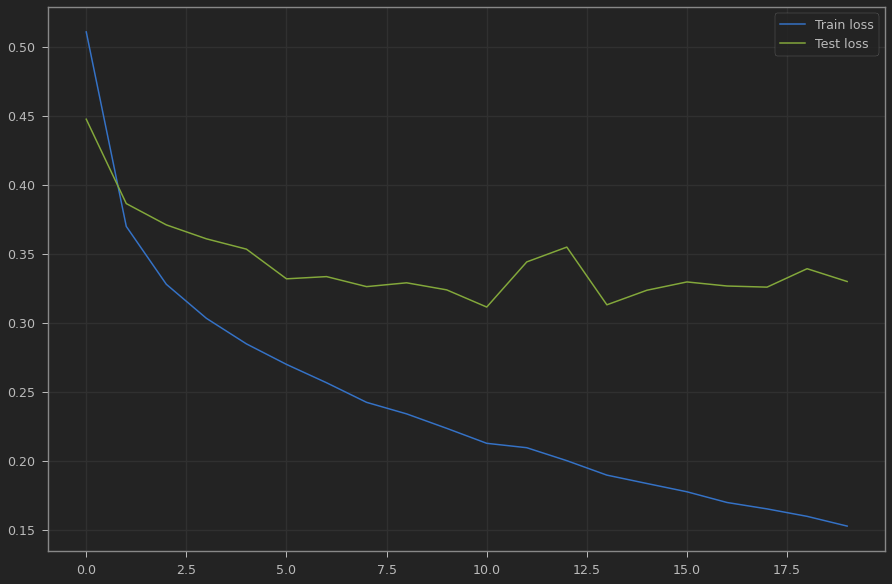

In [24]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()

In [25]:
# plot the accuracy of the model
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs, 1)
    
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
    
train_acc = n_correct / n_total

n_correct, n_total = 0, 0

for inputs, targets in test_loader :
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs, 1)
    
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total

print("Train acc : {:4f} | Test Acc : {:4f}".format(train_acc, test_acc))


Train acc : 0.950017 | Test Acc : 0.895600


Confusion matrix, without normalization
[[840   0  16  18   7   1 115   0   3   0]
 [  0 981   1  10   5   0   3   0   0   0]
 [ 18   0 848   9  65   0  60   0   0   0]
 [ 26   4  23 879  39   0  26   0   3   0]
 [  0   0 102  22 812   0  64   0   0   0]
 [  0   0   0   1   0 958   0  22   0  19]
 [ 95   0  87  25  55   0 736   0   2   0]
 [  0   0   0   0   0   6   0 978   0  16]
 [  7   0   5   3   4   1   8   4 968   0]
 [  0   0   0   0   0   3   1  40   0 956]]


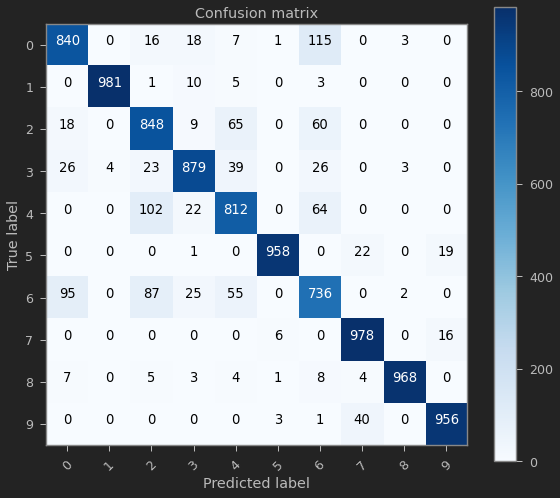

In [27]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
x_test = test_datasets.data.numpy()
y_test = test_datasets.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

plt.grid(b=False)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))



In [28]:
labels = """T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot""".split("\n")

Text(0.5, 1.0, 'True Label : Shirt | Predicted Label : Pullover')

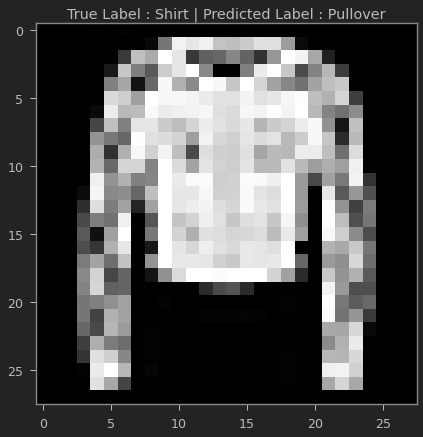

In [35]:
# Show some misclassified examples
plt.grid(b=False)
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
plt.title("True Label : {} | Predicted Label : {}".format(labels[y_test[i]], labels[p_test[i]]))